In [6]:
import zipfile
import os

# Go one level up from notebooks folder
zip_path = "/workspaces/Demand-Forecasting-Project/data/archive.zip"
extract_path = "../data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extraction
print(os.listdir(extract_path))


['Walmart.csv', 'archive.zip']


In [7]:
import pandas as pd

df = pd.read_csv("/workspaces/Demand-Forecasting-Project/data/Walmart.csv")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

ts = df.groupby('Date')['Weekly_Sales'].sum().sort_index()
print(ts.head())


Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Name: Weekly_Sales, dtype: float64


In [11]:
# Create time series
ts = df.groupby('Date')['Weekly_Sales'].sum().sort_index()

In [12]:
# Train-Test Split
train = ts[:-52]  # all but last year
test = ts[-52:]   # last year

In [13]:
# it SARIMA on train
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = model.fit()
print(sarima_result.summary())

/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Tue, 03 Feb 2026   AIC                             10.000
Time:                                    04:33:40   BIC                                nan
Sample:                                02-05-2010   HQIC                               nan
                                     - 10-28-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2392         -0       -inf      0.000       0.239       0.239
ma.L1         -0.7492         -0   

/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/workspaces/Demand-Forecasting-Project/venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice
  xo = x - x.mean()


In [14]:
#  Forecast next 52 weeks
forecast = sarima_result.forecast(steps=52)

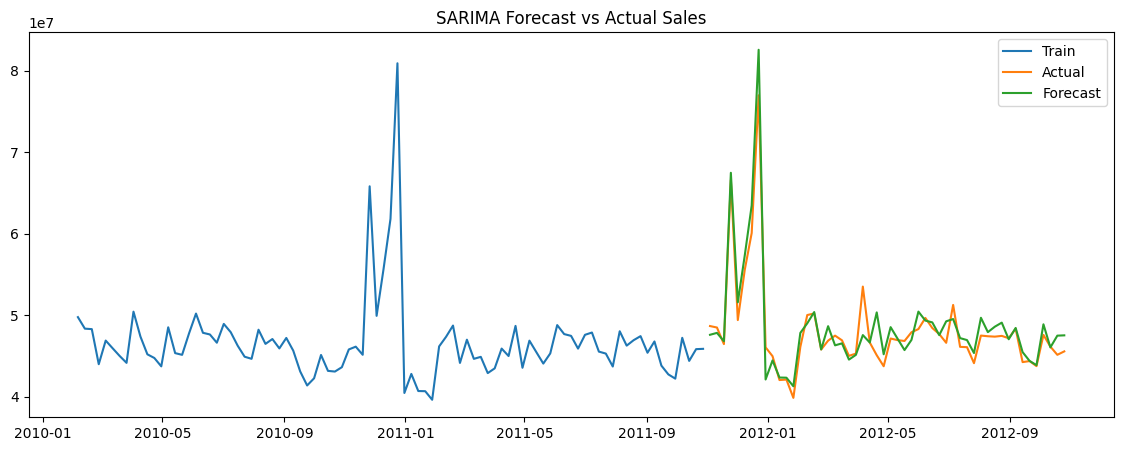

In [15]:
# Plot Forecast vs Actual
plt.figure(figsize=(14,5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title("SARIMA Forecast vs Actual Sales")
plt.legend()
plt.show()

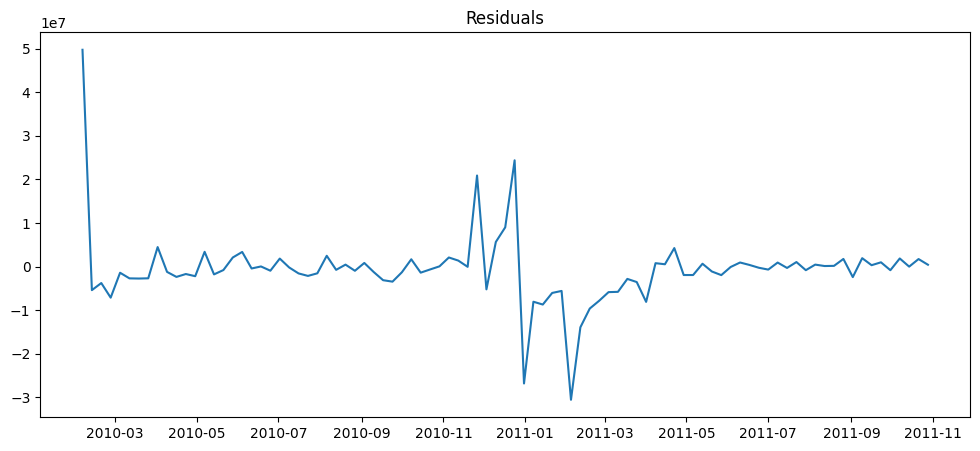

In [16]:
# Residuals plot
residuals = sarima_result.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1912299.01
MAPE: 2.69%
